In [4]:
import numpy as np
import matplotlib.pyplot as plt

from rutAnl160216 import * # En rutinasAnalisis160129.py residen todas las funciones basadas en las desarroladas en pulAnl160106.ipynb

import tek3 as tek3
test = tek3.TekScope("/dev/usbtmc1") # creo una instancia de tek3.TekScope
import time

# refresca de lo importado cada vez que se hace ejecución
%load_ext autoreload
%autoreload 2

%matplotlib inline
# coding=utf-8

ImportError: No module named 'tek3'

# Problema


Parece ser que no graba lo mismo que recoge en vivo.

## Recoge en vivo

Uso código sin modificaciones de `pulseTex2002B`

In [3]:
# lee settings

# test.load_setup() # Obtiene parámetros del osciloscopio
# sets= test.dico

def escalas(inst=test):
    # obtener una vez los límites verticales del canal
    pos1 = inst.get_channel_position(1)
    scale1 = inst.get_channel_scale(1)
    pos2 = inst.get_channel_position(2)
    scale2 = inst.get_channel_scale(2)
    return pos1, scale1, pos2, scale2


def param(osciloscopioTek):
    '''
    Grabo parámetros de la medición
    '''
    osciloscopioTek.load_setup() # Obtiene parámetros del osciloscopio
    sets= osciloscopioTek.dico
    [pos1, scale1, pos2, scale2]= escalas(osciloscopioTek)
    sets['POSITION1']= pos1
    sets['SCALE1']= scale1
    sets['POSITION2']= pos2
    sets['SCALE2']= scale2
    sets['ELECTRONICA']= 'Luis'
    return sets

settings= param()

NameError: name 'test' is not defined

In [61]:
# Lectura simple
def readBuff2(self):
    try:
        return self.ask('CURVE?')
    except TimeoutError:
        print('Probably requested channel has no data')
        raise

def ptsAdq():
    # correr una vez para obtener parámetros del buffer
    buff2 = readBuff2(test) # esta bien la herencia?
    dataPointsCharacters= int(buff2[1:2])
    dataOffset= 2+ dataPointsCharacters
    return (int(buff2[2:2+ dataPointsCharacters])), dataOffset # número de lecturas en cada adquisición

def rapi(dataCount, dataOffset):
    test.start_acq()
    while(test.textAsk('BUSY?')=='1'):
        time.sleep(1E-3)
    # return (np.frombuffer(readBuff2(test), dtype = np.dtype('int8').newbyteorder('<'), count= dataCount, offset= dataOffset) )  
    buff2 = readBuff2(test) # esta bien la herencia?
    return ( np.frombuffer(buff2, dtype = np.dtype('int8').newbyteorder('<'), count= dataCount, offset= dataOffset) )

def lectura(adquisiciones, puntosAdquisicion, dataOffset, tiempoInicial):
    # la lectura en sí
    ch1= np.empty([adquisiciones,puntosAdquisicion], dtype ='int8')
    ch2= np.empty([adquisiciones,puntosAdquisicion], dtype ='int8')
    zeit= test.temps() # zeit
    # zeit= tek3.TekScope.Xaxis(test) # zeit
    for medicion in range(adquisiciones):
        print('\rmedición '+ str(medicion)+ ' de '+ str(adquisiciones), end=' ')
        test.set_data_source(1) # canal 2
        ch1[medicion]= rapi(puntosAdquisicion, dataOffset)
        test.set_data_source(2) # canal 2
        ch2[medicion]= rapi(puntosAdquisicion, dataOffset)
    print('\rmedición '+ str(medicion+ 1)+ ' de '+ str(adquisiciones))
    print('Tiempo transcurrido= {:.1f} min'.format((time.time()- tiempoInicial)/60) ) # tiempo transcurrido en segundos
    return zeit, ch1, ch2

[puntosAdquisicion, dataOffset] = ptsAdq() # puntos por cada adquisición, headbits en cada adquisición
[zeit, ch1, ch2]=lectura(1, puntosAdquisicion, dataOffset, 0)

medición 1 de 1
Tiempo transcurrido= 24269297.4 min


In [66]:
cosaCh1= (4E-2* ch1[0]- np.float(settings['POSITION1']) )* np.float(settings['SCALE1'])
cosaCh2= (4E-2* ch2[0]- np.float(settings['POSITION2']) )* np.float(settings['SCALE2'])

In [63]:
4E-2

0.04

(-4.9999999999999998e-07, 4.9960000000000016e-07)

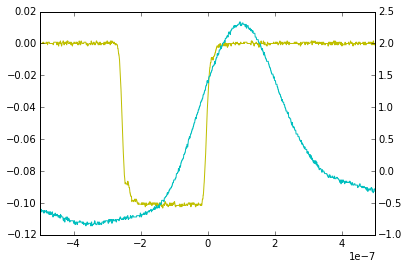

In [67]:
plt.plot(zeit, cosaCh1, 'y')
plt.twinx()
plt.plot(zeit, cosaCh2, 'c')
plt.xlim(zeit[0], zeit[2499])
plt.xlim()

Todo lindo y bonito. Se condice con lo que observo en la pantalla.

## Levanto desde un archivo

Hago 10 adquisiciones usando `pulseTex2002B` en el archivo `pul160222z01.npy.npz`

In [70]:
tipo= 'pul'
anne= 16
mes= 2
dia= 22
rango= np.arange(1,2)

In [71]:
i= 1
acq= np.load(dataPathFile2(tipo, anne, mes, dia, i))

In [72]:
settingsList= acq['settings'].tolist()
settingsList

{':MATH:FFT:HORIZONTAL:POSITION': '5.0E1',
 'LAYOUT': 'PORTRAIT',
 'PORT': 'USB',
 'DATEPRINT': 'DEFLT',
 ':SELECT:CH1': '1',
 'STYLE': 'VECTORS',
 'WIDTH:POLARITY': 'POSITIVE',
 'WHEN': 'EQUAL',
 'STANDARD': 'NTSC',
 'SCALE': '1.0E0',
 ':LANGUAGE': 'SPANISH',
 'POSITION1': 2.0,
 ':CH1:PROBE': '1.0E0',
 'YUNIT': '"V"',
 'REFA': '0',
 'SELECT:SOURCE': 'CH1',
 'SOURCE': 'CH2',
 'STOP': '2500',
 ':PICTBRIDGE:PAPERSIZE': 'DEFLT',
 'LINE': '1',
 'STOPAFTER': 'SEQUENCE',
 ':TRIGGER:MAIN:VIDEO:SOURCE': 'CH1',
 ':ACQUIRE:MODE': 'SAMPLE',
 'INKSAVER': 'ON',
 ':MEASUREMENT:MEAS1:TYPE': 'PK2PK',
 'SYNC': 'FIELD',
 'SCALE1': 0.02,
 'MAIN:SCALE': '1.0E-7',
 'CONTRAST': '54',
 'NUMAVG': '16',
 'SCALE2': 0.5,
 ':CURSOR:VBARS:UNITS': 'SECONDS',
 ':HARDCOPY:BUTTON': 'SAVESALL',
 'STATE': '0',
 'SLOPE': 'RISE',
 'WIDTH': '1.0E-3',
 ':TRIGGER:MAIN:PULSE:SOURCE': 'CH1',
 'CURRENTPROBE': '1.0E1',
 ':LOCK': 'NONE',
 ':VERBOSE': '1',
 'MATH': '0',
 'TYPE': 'EDGE',
 ':HORIZONTAL:VIEW': 'MAIN',
 'POLARITY': 'N

In [73]:
TArchivo= acq['zeit']
ch1Archivo= acq['ch1'][0]
ch2Archivo= acq['ch2'][0]

In [87]:
cosaArchivoCh1= (4E-2* ch1Archivo+ np.float(settingsList['POSITION1']) )* (-1)* np.float(settingsList['SCALE1'])
cosaArchivoCh2= (4E-2* ch2Archivo- np.float(settingsList['POSITION2']) )* np.float(settingsList['SCALE2'])

(-4.9999999999999998e-07, 4.9960000000000016e-07)

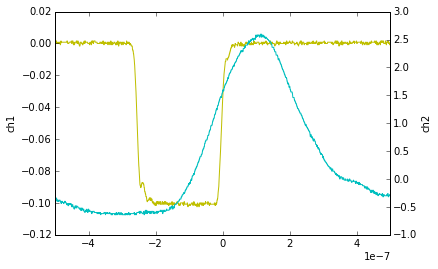

In [92]:
plt.plot(TArchivo, cosaArchivoCh1, 'y')
plt.ylabel('ch1')
plt.twinx()
plt.plot(T, cosaArchivoCh2, 'c')
plt.ylabel('ch2')
plt.xlim(T[0], T[2499])
plt.xlim()

Tomando el recaudo que corresponde en los signos de conversión coinciden ambos gráficos.